# Лабораторная работа 1
# Фильтр Байеса

В начале помещения находится мобильный робот с координатой 0 в помещении длиной SIZE.  Робот перемещается вдоль одного направления по ячейкам шириной 1 метр. Исполнительные механизмы робота неидеальны, а также присутствует проскальзывание. Вследствие этого, робот перемещеается в заданную ячейку с вероятностью 40%, в соседнюю с ней - с вероятностью 20%, через одну от нее - 10%. Гистограмма погрешности приведена ниже.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.stats import norm

seed = 7
random.seed(seed)
np.random.seed(seed)

<BarContainer object of 5 artists>

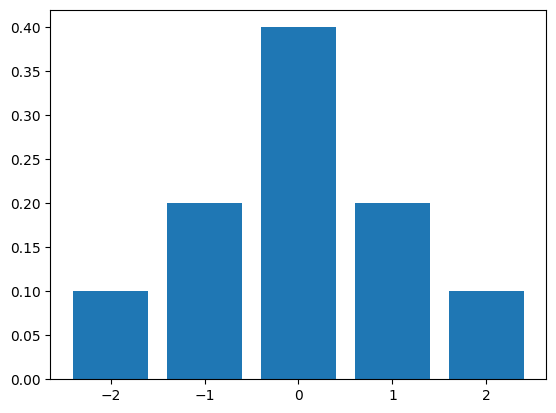

In [ ]:
robot_errors = [-2, -1, 0, 1, 2]
robot_prob = [0.1, 0.2, 0.4, 0.2, 0.1]
plt.bar(robot_errors, robot_prob)

Положение робота измеряется датчиком с нормальным распределением погрешности, математическое ожидание которой соотвествует положению робота. Рапределение погрешности датчика приведено ниже.

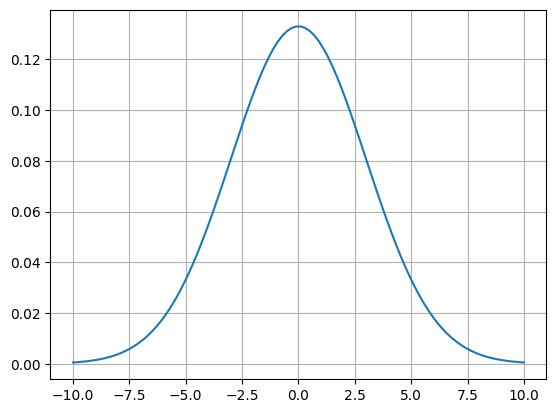

In [ ]:
def sens_pos_def(mu=0, sigma=3, N=100):
  x = np.linspace(mu-10, mu+10, N)
  p = (2 * np.pi * (sigma ** 2)) ** (-0.5) * np.exp(-0.5 * np.power( x - mu, 2)/ (sigma ** 2))
  return p, x
p, x = sens_pos_def()
plt.plot(x, p)
plt.grid(True)

Робот выполняет перемещение в произвольно заданную ячейку $N$. После чего измеряет положение датчиком и применяет фильтр Байеса для уточнения своего положения (данные положения робот может запрашивать сколько потребуется раз). 

## Задание

Требуется:

- Написать программный код, иммитирующий изменение распределения плотности вероятности нахождения робота в ячейках при перемещении (допускается, что робот перемещается в центр ячейки).
- Реализовать функцию, иммитируюущую измерение положения робота датчиком.
- Написать функцию, реализующую фильтр Байеса для определения положения робота.
- Построить график зависимости максимальной вероятности нахождения робота в ячейке от количества измерений.
- Построить график распределения плотности вероятности положения робота после многократных измерений.
- Повторить два предыдущих пункта для трех перемещений при различных среднеквадратических отклонениях показаний датчика.

Задаем длину помещения и область поиска соответственно. Необходимо отметить, что в данной реализации область поиска состоит из целых чисел

In [ ]:
size = 10
SEARCH_AREA = np.arange(size + 1)
X_MIN = SEARCH_AREA[0]
X_MAX = SEARCH_AREA[-1]

Напишем функцию перемещения робота в ячейку N, при этом учтем неидеальность исполнительных механизмов 

In [ ]:
def move_robot(robot_errors, robot_prob, N):
    # Генерация случайного смещения на основе вероятностей
    position = random.choices(robot_errors, robot_prob)[0] + N
    return position

In [ ]:
N = size // 2
print('Желаемое положение', N)
position = move_robot(robot_errors, robot_prob, N=N)
print('Действительное положение', position)

Желаемое положение 5
Действительное положение 5


Иммитация изменения распределения плотности вероятности нахождения робота в ячейках при перемещении <br>

<BarContainer object of 5 artists>

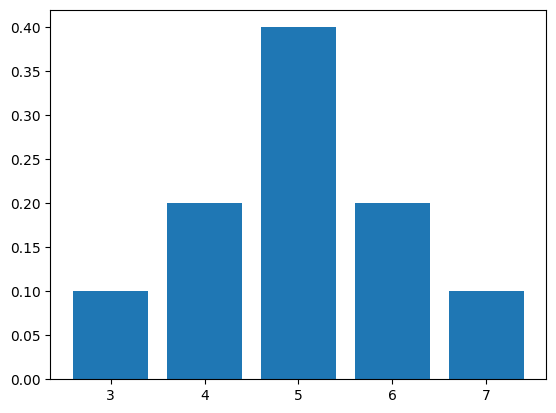

In [ ]:
prob_pos = np.array([-2, -1, 0, 1, 2]) + N
robot_prob = [0.1, 0.2, 0.4, 0.2, 0.1]
plt.bar(prob_pos, robot_prob)

Априорное распределение

In [ ]:
prior = [robot_prob[prob_pos.tolist().index(i)] if i in prob_pos else 0 for i in SEARCH_AREA]
print(prior)

[0, 0, 0, 0.1, 0.2, 0.4, 0.2, 0.1, 0, 0, 0]


Функция, иммитируюущая измерение положения робота датчиком.

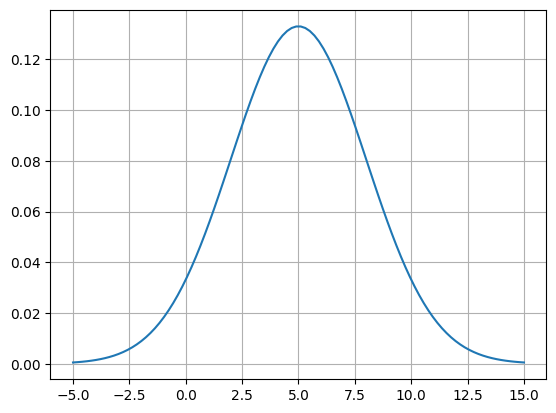

In [ ]:
sens_pos, x = sens_pos_def(mu=position)
plt.plot(x, sens_pos)
plt.grid(True)

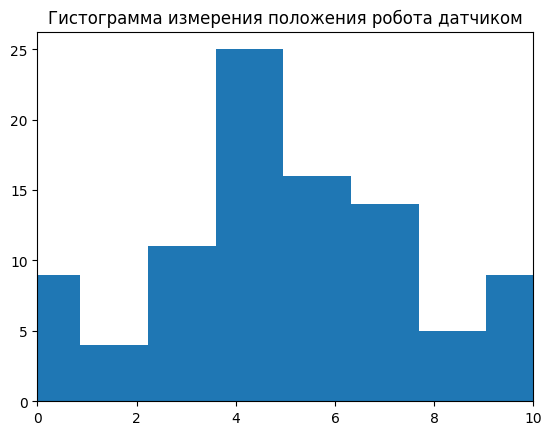

In [ ]:
N = 100  # число измерений
SD = 3 # дисперсия
sens_pos = SD * np.random.randn(N) + position

fig, ax = plt.subplots()

ax.hist(sens_pos)
ax.set(xlim=(X_MIN, X_MAX), title='Гистограмма измерения положения робота датчиком')
plt.show()

In [ ]:
def bayes_formula(prior, y):
    numerator = []
    for i in range(len(SEARCH_AREA)):
        numerator.append(prior[i] * norm.pdf(x=y, loc=SEARCH_AREA[i], scale=SD))
    return numerator/np.sum(numerator)

In [ ]:
posteriors = [prior]  # Список функций плотностей распределения от опыта к опыту

for obj in sens_pos:
    prior = posteriors[len(posteriors)-1]
    posterior = bayes_formula(prior=prior, y=obj)
    posteriors.append(posterior)

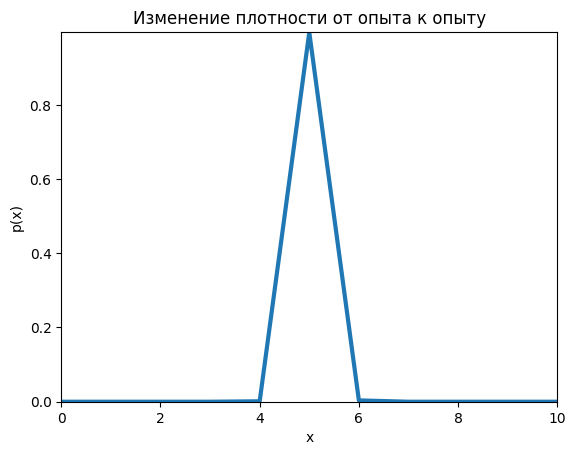

In [ ]:
%matplotlib inline

from matplotlib.animation import FuncAnimation
fig, ax = plt.subplots()                    
ax.set(xlim=(X_MIN, X_MAX), ylim=(0, np.max(posteriors)), title='Изменение плотности от опыта к опыту')
ax.set_xlabel("x")
ax.set_ylabel("p(x)")
line, = ax.plot([], [], lw=3)

def init():
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(SEARCH_AREA, posteriors[i])
    return line,

anim = FuncAnimation(fig, animate, init_func=init, frames=N, interval=80, blit=True)
anim.save('posteriors.gif', writer='matplotlib.animation.PillowWriter')

Text(0.5, 1.0, 'Зависимость максимальной вероятности \n нахождения робота в ячейке от количества измерений')

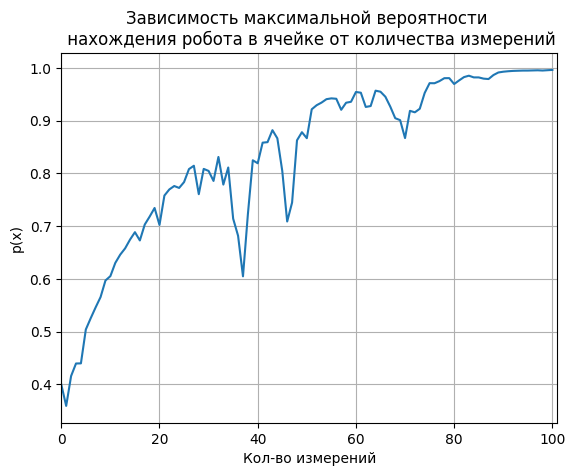

In [ ]:
val = []
for i in range(len(posteriors)):
  val.append(posteriors[i][position])

x = range(len(posteriors)) 

plt.plot(x, val)
plt.xlabel('Кол-во измерений')
plt.ylabel('p(x)')
plt.xlim(0, len(posteriors))
plt.grid(True)
plt.title('Зависимость максимальной вероятности \n нахождения робота в ячейке от количества измерений')

## Задание 2

Желаемое положение 7
Действительное положение 6


<BarContainer object of 5 artists>

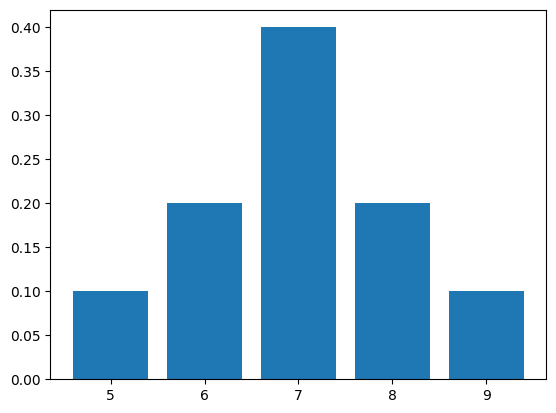

In [ ]:
N = 7
print('Желаемое положение', N)
position = move_robot(robot_errors, robot_prob, N=N)
print('Действительное положение', position)

prob_pos = np.array([-2, -1, 0, 1, 2]) + N
robot_prob = [0.1, 0.2, 0.4, 0.2, 0.1]
plt.bar(prob_pos, robot_prob)

In [ ]:
prior = [robot_prob[prob_pos.tolist().index(i)] if i in prob_pos else 0 for i in SEARCH_AREA]
print(prior)

[0, 0, 0, 0, 0, 0.1, 0.2, 0.4, 0.2, 0.1, 0]


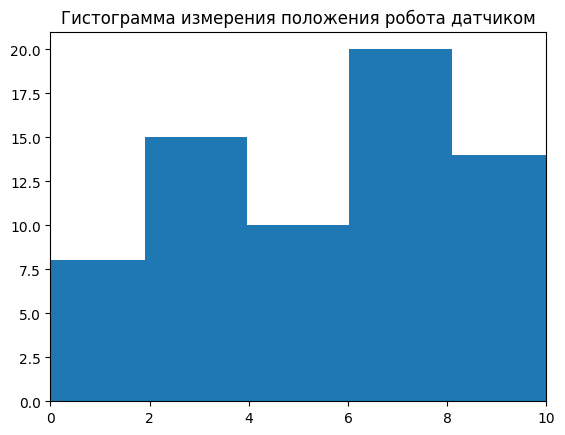

In [ ]:
N = 100  # число измерений
SD = 5 # дисперсия
sens_pos = SD * np.random.randn(N) + position

fig, ax = plt.subplots()

ax.hist(sens_pos)
ax.set(xlim=(X_MIN, X_MAX), title='Гистограмма измерения положения робота датчиком')
plt.show()

In [ ]:
posteriors = [prior]  # Список функций плотностей распределения от опыта к опыту

for obj in sens_pos:
    prior = posteriors[len(posteriors)-1]
    posterior = bayes_formula(prior=prior, y=obj)
    posteriors.append(posterior)

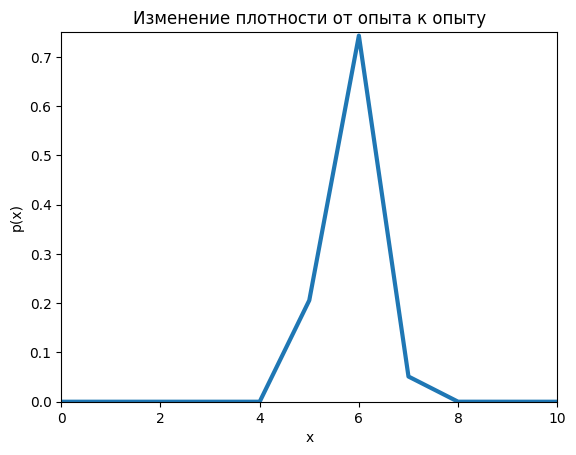

In [ ]:
%matplotlib inline

from matplotlib.animation import FuncAnimation
fig, ax = plt.subplots()                    
ax.set(xlim=(X_MIN, X_MAX), ylim=(0, np.max(posteriors)), title='Изменение плотности от опыта к опыту')
ax.set_xlabel("x")
ax.set_ylabel("p(x)")
line, = ax.plot([], [], lw=3)

def init():
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(SEARCH_AREA, posteriors[i])
    return line,

anim = FuncAnimation(fig, animate, init_func=init, frames=N, interval=80, blit=True)
anim.save('posteriors2.gif', writer='matplotlib.animation.PillowWriter')

Text(0.5, 1.0, 'Зависимость максимальной вероятности \n нахождения робота в ячейке от количества измерений')

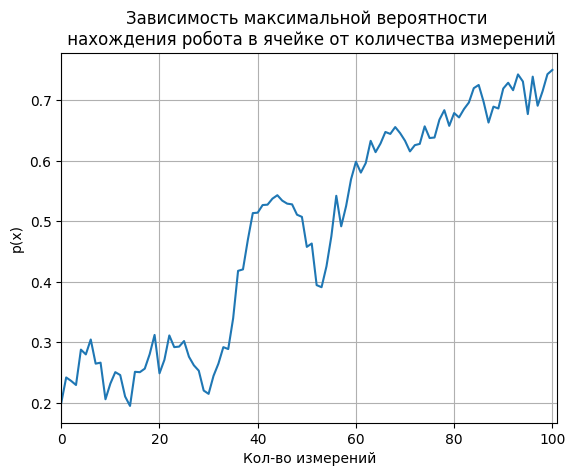

In [ ]:
val = []
for i in range(len(posteriors)):
  val.append(posteriors[i][position])

x = range(len(posteriors))

plt.plot(x, val)
plt.xlabel('Кол-во измерений')
plt.ylabel('p(x)')
plt.xlim(0, len(posteriors))
plt.grid(True)
plt.title('Зависимость максимальной вероятности \n нахождения робота в ячейке от количества измерений')

## Задание 3

Желаемое положение 6
Действительное положение 6


<BarContainer object of 5 artists>

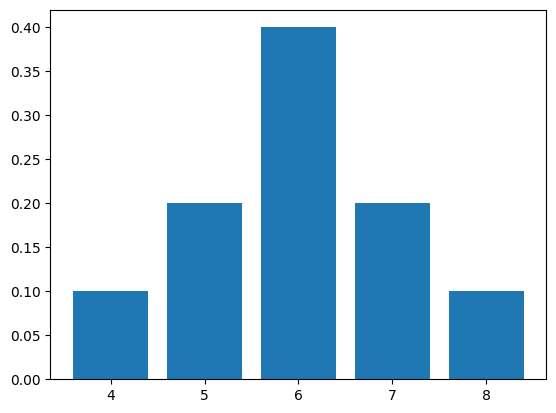

In [ ]:
N = 6
print('Желаемое положение', N)
position = move_robot(robot_errors, robot_prob, N=N)
print('Действительное положение', position)

prob_pos = np.array([-2, -1, 0, 1, 2]) + N
robot_prob = [0.1, 0.2, 0.4, 0.2, 0.1]
plt.bar(prob_pos, robot_prob)

In [ ]:
prior = [robot_prob[prob_pos.tolist().index(i)] if i in prob_pos else 0 for i in SEARCH_AREA]
print(prior)

[0, 0, 0, 0, 0.1, 0.2, 0.4, 0.2, 0.1, 0, 0]


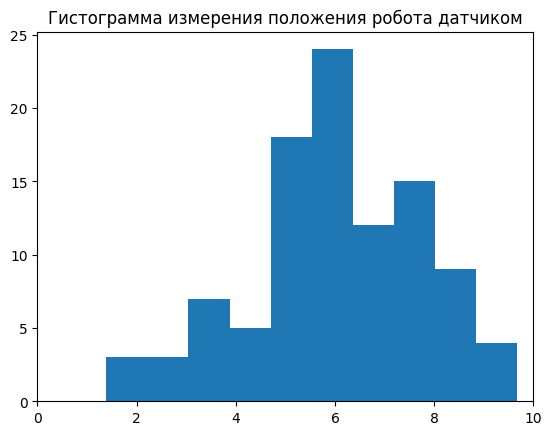

In [ ]:
N = 100  # число измерений
SD = 2 # дисперсия
sens_pos = SD * np.random.randn(N) + position

fig, ax = plt.subplots()

ax.hist(sens_pos)
ax.set(xlim=(X_MIN, X_MAX), title='Гистограмма измерения положения робота датчиком')
plt.show()

In [ ]:
posteriors = [prior]  # Список функций плотностей распределения от опыта к опыту

for obj in sens_pos:
    prior = posteriors[len(posteriors)-1]
    posterior = bayes_formula(prior=prior, y=obj)
    posteriors.append(posterior)

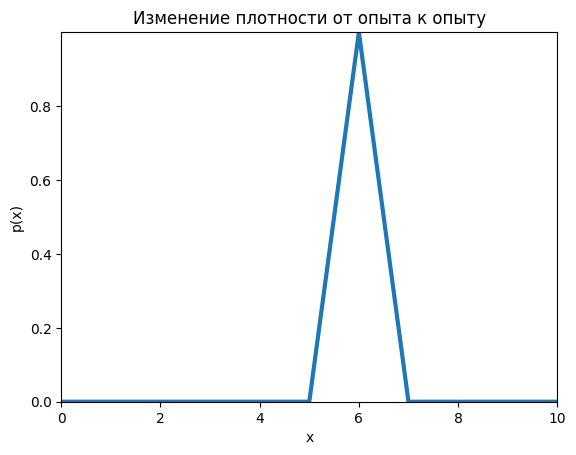

In [ ]:
%matplotlib inline

from matplotlib.animation import FuncAnimation
fig, ax = plt.subplots()                    
ax.set(xlim=(X_MIN, X_MAX), ylim=(0, np.max(posteriors)), title='Изменение плотности от опыта к опыту')
ax.set_xlabel("x")
ax.set_ylabel("p(x)")
line, = ax.plot([], [], lw=3)

def init():
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(SEARCH_AREA, posteriors[i])
    return line,

anim = FuncAnimation(fig, animate, init_func=init, frames=N, interval=80, blit=True)
anim.save('posteriors3.gif', writer='matplotlib.animation.PillowWriter')

Text(0.5, 1.0, 'Зависимость максимальной вероятности \n нахождения робота в ячейке от количества измерений')

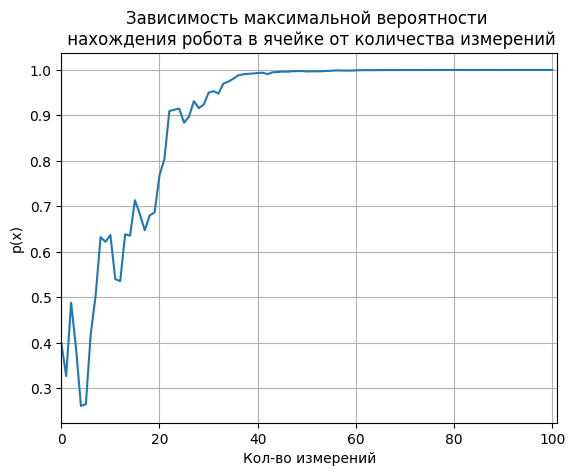

In [ ]:
val = []
for i in range(len(posteriors)):
  val.append(posteriors[i][position])

x = range(len(posteriors))

plt.plot(x, val)
plt.xlabel('Кол-во измерений')
plt.ylabel('p(x)')
plt.xlim(0, len(posteriors))
plt.grid(True)
plt.title('Зависимость максимальной вероятности \n нахождения робота в ячейке от количества измерений')